A1a A1b | A2 | A3 || Σ <br>
—————————————————————————————————————<br>
1/1 1/1 | 0.5/2  | 6/6 || 8.5/10 

Lorenzo Wormer, 1923031, 10.12.2020

# TMB: Exercize sheet 2

See handwritten notes for exercizes 1 and 2. Notebook has to be run with Python 3.

## Exercize 3

In [17]:
import math
from scipy import constants
import random as rd
import matplotlib.pyplot as plt

### Define constants

In [18]:
iterations = 10000
T = 300 # in Kelvin, arbitrary choice, as exercize sheet didn't specify temperature

k_b = constants.Boltzmann
beta = 1 / (k_b * T)

### Define a few functions: 

In [19]:
def calc_helix_length(s):
    """Calculate the length of the helix from the current state
    
    Parameters:
    s (int): State of the system, a.k.a. lstart and end position of helix

    Returns:
    int: Helix length
    """

    return abs(s[1] - s[0])

In [20]:
def calc_energy(l, e, n):
    """Calculate the energy for a certain length of the single helix fragment
    
    Parameters:
    l (int): Length of single helix fragment (0 <= l <= L)
    e (float): As defined on exercize sheet
    n (float): As defined on exercize sheet

    Returns:
    float: Energy for the given length
    """
    
    return n * (1 if l > 0 else 0) + (l-1) * e

In [21]:
def calc_boltzmann(E):
    """Calculate e^(-beta * E) for a given energy E (needed in other calculations)
    
    Parameters:
    E (float): Energy value

    Returns:
    float: Non-normalized probability of energy E accodrding to boltzmann distribution
    """

    return math.exp(-beta * E)

In [22]:
def calc_transition_probability(E_i, E_j):
    """Calculate the trasition probability from state i to state j
    
    Parameters:
    E_i (float): Energy of state i
    E_j (float): Energy of state j

    Returns:
    float: Probability of transition from i to j
    """

    return calc_boltzmann(E_j - E_i) if E_j > E_i else 1

In [23]:
def calc_state_probability(E, Z):
    """Directly calculate the probability of a given state (helix length)
    
    Parameters:
    E (float): energy of current state
    Z (float): partition function

    Returns:
    float: probability of given state
    """

    return calc_boltzmann(E) / Z

In [24]:
def gen_position_proposal(x, L):
    """Generate a proposal for the shift of a position within the chain (could be start or end of the helix)
    
    Parameters:
    x (int): Position within chain (0 <= l <= L)
    L (int): Total chain length

    Returns:
    int: Proposed shifted position
    """

    x_prop = x

    # take a random walk with possible steps +1, -1 and 0 on each iteration, stop as soon as 0 is proposed for the step size:
    while True:
        step = rd.choice([
            -1 if x_prop > 0 else 0, 
            0, 
            1 if x_prop < L else 0
        ])

        x_prop += step

        if(step == 0): break
    
    return x_prop

In [25]:
def get_next_state(state, e, n, L):
    """Generate the next state from the current by making a random proposal and accepting it according to transition probability
    
    Parameters:
    state (tuple of int): current start and end of helix
    e (float): As defined on exercize sheet
    n (float): As defined on exercize sheet
    L (int): Total chain length

    Returns:
    tuple of int: next state (length of helix fragment)
    """

    proposal = (
        gen_position_proposal(state[0], L), 
        gen_position_proposal(state[1], L)
    )

    old_length = calc_helix_length(state)
    new_length = calc_helix_length(proposal)

    probability = calc_transition_probability(
        calc_energy(old_length, e, n), 
        calc_energy(new_length, e, n)
    )

    return proposal if rd.random() < probability else state

In [26]:
def run_simulation_and_compare(n, e, L):
    """First calculate the target distribution directly, then run a MCMC simulation to approximate it, then plot both results

    Parameters:
    n (float): As defined on exercize sheet
    e (float): As defined on exercize sheet
    L (int): Total chain length

    Returns:
    None
    """

    # target:

    Z = sum((calc_boltzmann(calc_energy(l, e, n)) for l in range(0, L+1))) # partition function
    target_distro = [iterations * calc_state_probability(calc_energy(l, e, n), Z) for l in range(0, L+1)]


    # MCMC Simulation:

    # represent state by two positions within the chain, which are start and end of the single helix fragment:
    state = (rd.randint(0, L), rd.randint(0, L)) 

    # store counts of states aggregated by the corresponding helix length:
    sim_counts = [0] * (L+1)

    # iterate:
    for i in range(0, iterations):
        state = get_next_state(state, e, n, L)
        sim_counts[calc_helix_length(state)] += 1

    # plotting:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.bar([l for l in range(0, L+1)], target_distro)
    ax1.set_title("Target")
    ax1.axis([0-L/10, L+L/10, 0, iterations])
    ax2.bar([l for l in range(0, L+1)], sim_counts)
    ax2.set_title("Approximation via MCMC")
    ax2.axis([0-L/10, L+L/10, 0, iterations])
    plt.show()

### Run the simulation on multiple variations of the model parameters (n, e, L):

In [27]:
# default model parameters:
L = 5
n = 2 * k_b * T 
e = -k_b * T

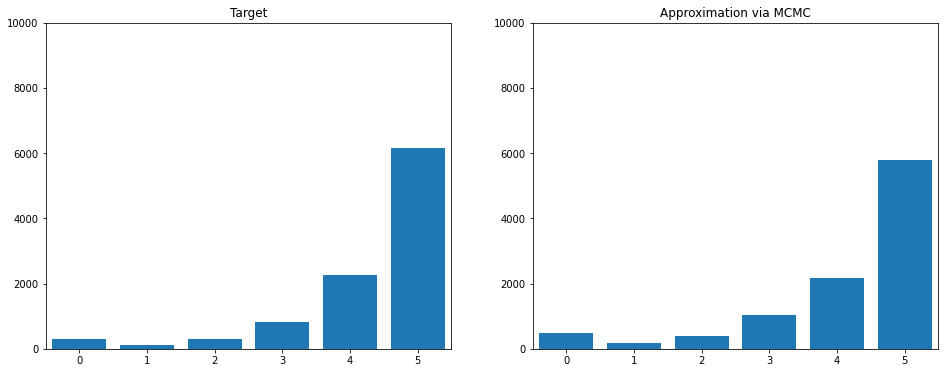

In [28]:
# first leave them as defined above:
run_simulation_and_compare(n, e, L)

-> Distributions match quite well. MCMC seems to have converged. The maximum at l = L is to be expected, as the system's total energy decreases linearily with increasing length of the helix fragment.

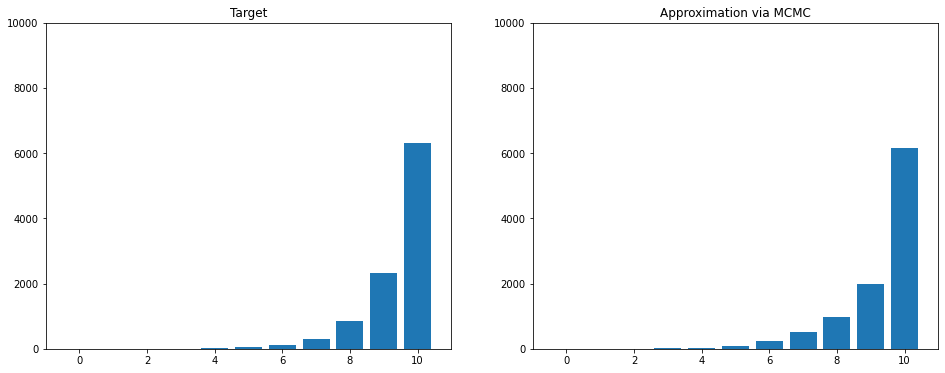

In [29]:
# double the total length:
run_simulation_and_compare(n, e, L*2)

-> Not very surprising..

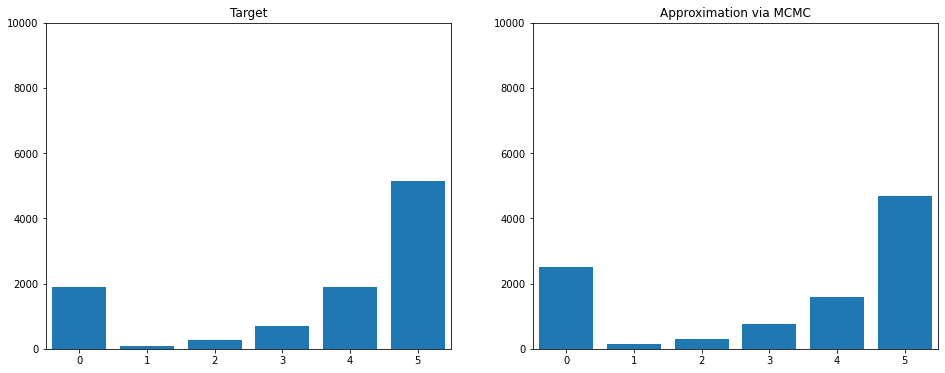

In [30]:
# change L back, double n:
run_simulation_and_compare(n*2, e, L)

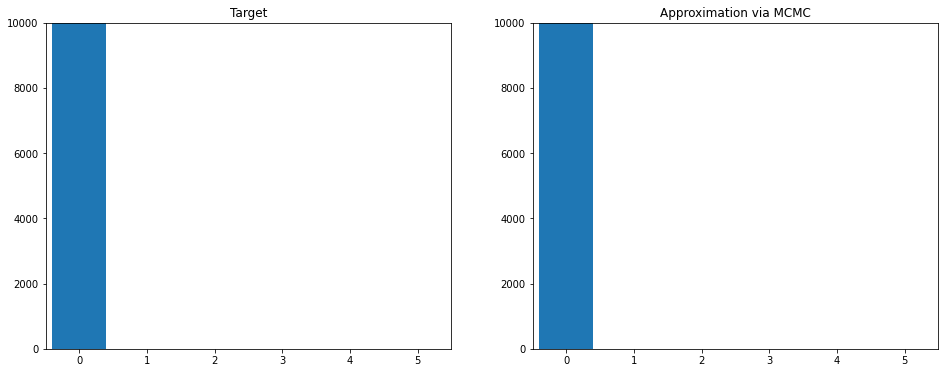

In [31]:
# change n to something by one magnitude:
run_simulation_and_compare(n*10, e, L)

-> n could be interpreted as the fixed energy cost of forming a single helix (independent of the length). If n is far larger than the energy decrease e for adding new elements to the helix, no helix will form, hence l = 0.

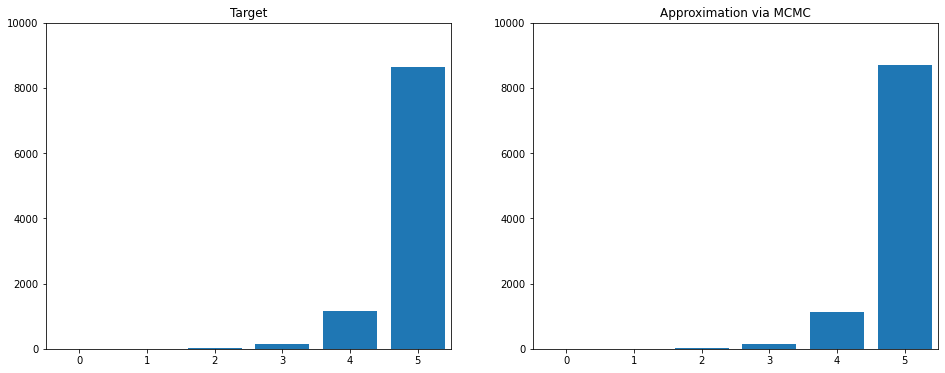

In [32]:
# change n back, double e:
run_simulation_and_compare(n, e*2, L)

-> Narrower distribution around peak at l = L, which is expected, as the energy of the system decreases quicker with elongation of the helix for a larger value of e.